
| **Dataset Link** | 
 [MINST Link](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)| [CIFAR-10 Link](https://www.kaggle.com/datasets/pankrzysiu/cifar10-python)|

Key Features:  
- **Custom CNN Design**: Depth-wise separable convolutions, reduced channels, no batch norm for minimal overhead.  
- **Optimizations**: Pruning, 8-bit quantization, and Lottery Ticket Hypothesis.  
- **Green Metrics**: Measured with CodeCarbon for real sustainability insights.  
- **Visualizations**: Accuracy vs. GFLOPs, CO2 emissions, and more.  

Dive in to see how small models can make a big environmental impact!

# 1 Install Dependencies

In [1]:
# Cell 1: Install Dependencies
!pip install codecarbon ptflops torchsummary

# Imports
import torch, os, time, gzip, pickle, copy, struct
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.quantization import quantize_dynamic
import torch.nn.utils.prune as prune
from codecarbon import EmissionsTracker
from ptflops import get_model_complexity_info
import numpy as np
import pandas as pd
from ptflops import get_model_complexity_info
from sklearn.metrics import precision_score, roc_auc_score
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision.models import resnet18
from torchvision.models import mobilenet_v2

# Device Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.6/357.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda


# 2 Load Datasets and Transform

In [2]:
# Cell 2: Load Datasets

# Helper function to load IDX files
def load_idx(filename):
    with open(filename, 'rb') as f:
        # Read header
        magic = f.read(4)
        data_type = struct.unpack('>B', magic[2:3])[0]  # 8 for uint8
        dims = struct.unpack('>B', magic[3:4])[0]
        shape = []
        for _ in range(dims):
            shape.append(struct.unpack('>I', f.read(4))[0])
        # Read data
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(shape)
    return data

# Load MNIST from IDX files with nested paths
mnist_dir = '/kaggle/input/mnist-dataset/'

train_images_path = os.path.join(mnist_dir, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
train_labels_path = os.path.join(mnist_dir, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_path = os.path.join(mnist_dir, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_path = os.path.join(mnist_dir, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

train_images = load_idx(train_images_path)
train_labels = load_idx(train_labels_path)
test_images = load_idx(test_images_path)
test_labels = load_idx(test_labels_path)

# Custom Dataset for MNIST (grayscale images)
class MnistDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.float32)  # Ensure float for transform
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = MnistDataset(train_images, train_labels, transform=transform_mnist)
mnist_test = MnistDataset(test_images, test_labels, transform=transform_mnist)

mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1000, shuffle=False)


# Load CIFAR-10 from batch files
cifar_dir = '/kaggle/input/cifar10-python/cifar-10-batches-py'  # Corrected path based on mounted dataset

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load training batches
train_data = []
train_labels = []
for i in range(1, 6):
    batch = unpickle(os.path.join(cifar_dir, f'data_batch_{i}'))
    train_data.append(batch[b'data'])
    train_labels.extend(batch[b'labels'])
train_data = np.vstack(train_data)

# Load test batch
test_batch = unpickle(os.path.join(cifar_dir, 'test_batch'))
test_data = test_batch[b'data']
test_labels = test_batch[b'labels']

# Custom Dataset for CIFAR-10
class CifarDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx].reshape(3, 32, 32).transpose(1, 2, 0).astype(np.uint8)
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar_train = CifarDataset(train_data, train_labels, transform=transform_cifar)
cifar_test = CifarDataset(test_data, test_labels, transform=transform_cifar)

cifar_train_loader = DataLoader(cifar_train, batch_size=64, shuffle=True)
cifar_test_loader = DataLoader(cifar_test, batch_size=1000, shuffle=False)

# 3 Visualize Images from MNIST and CIFAR-10 Datasets

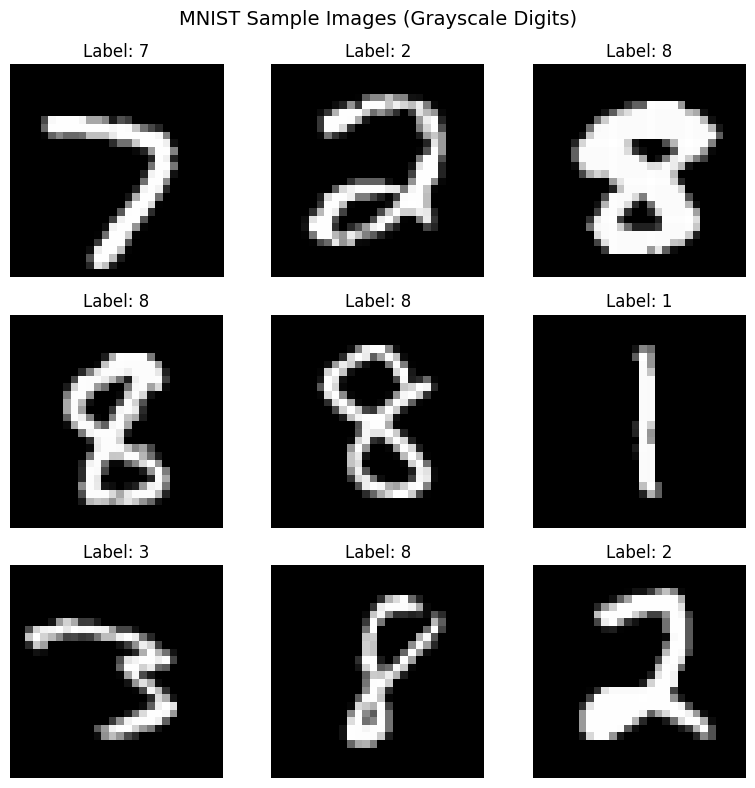

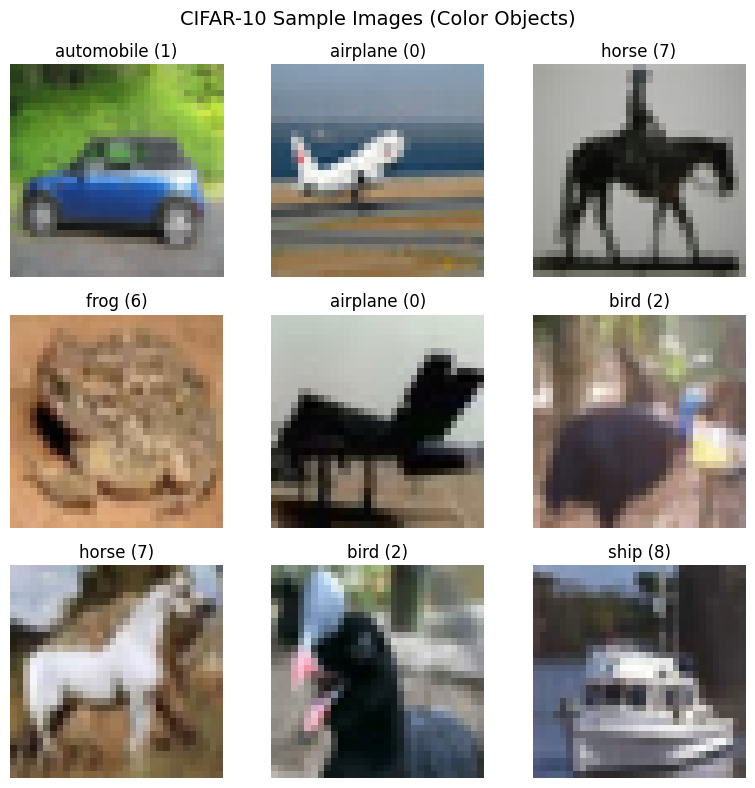

In [3]:
# Visualize Sample Images from MNIST and CIFAR-10 Datasets
import random

# Function to visualize images from a loader
def visualize_samples(loader, title, num_samples=9, is_grayscale=False, class_names=None):
    # Get a batch
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    # Select random indices
    indices = random.sample(range(len(images)), num_samples)
    selected_images = images[indices]
    selected_labels = labels[indices]
    
    # Plot grid
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()
    for i in range(num_samples):
        img = selected_images[i].numpy().transpose(1, 2, 0) if not is_grayscale else selected_images[i].numpy().squeeze()
        if is_grayscale:
            axes[i].imshow(img, cmap='gray')
        else:
            img = np.clip(img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465]), 0, 1)  # Denormalize for display
            axes[i].imshow(img)
        label = selected_labels[i].item()
        axes[i].set_title(f"Label: {label}" if class_names is None else f"{class_names[label]} ({label})")
        axes[i].axis('off')
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# CIFAR-10 class names
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize MNIST (grayscale)
visualize_samples(mnist_test_loader, "MNIST Sample Images (Grayscale Digits)", is_grayscale=True)

# Visualize CIFAR-10 (color)
visualize_samples(cifar_test_loader, "CIFAR-10 Sample Images (Color Objects)", class_names=cifar_classes)

# 4 Define Custom Lightweight CNN

In [4]:
# Custom Lightweight CNN Class (Works for Both MNIST and CIFAR-10)

class LightweightCNN(nn.Module):
    def __init__(self, num_classes=10, input_channels=1):  # Default for MNIST; set to 3 for CIFAR-10
        super(LightweightCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)  # Small kernel, initial channels
        self.act1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Depth-wise separable conv (fixed: groups must match in_channels for depthwise)
        self.depthwise = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, groups=16)  # Groups = in_channels (correct for depthwise)
        self.pointwise = nn.Conv2d(16, 32, kernel_size=1)
        self.act2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout = nn.Dropout(0.25)
        
        # Reduced channels in FC (fixed: Linear input size; typo corrected from 164 to 64)
        fc_input_size = 32 * 7 * 7 if input_channels == 1 else 32 * 8 * 8  # 28x28 → 7x7 after pools; 32x32 → 8x8
        self.fc1 = nn.Linear(fc_input_size, 64)  # Reduced from 128 to 64 for efficiency
        self.act3 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)  # Corrected from 164 (typo) to 64
    
    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.pointwise(self.depthwise(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act3(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Instantiate for MNIST and CIFAR-10
custom_mnist = LightweightCNN(num_classes=10, input_channels=1).to(device)
custom_cifar = LightweightCNN(num_classes=10, input_channels=3).to(device)

# 5 Load Pre-trained MobileNetV2, ResNet18 and 

In [5]:
# Cell 5: Load Pre-trained MobileNetV2
def get_mobilenetv2(num_classes=10, input_channels=1):
    model = models.mobilenet_v2(pretrained=True)
    
    # Adjust for grayscale if MNIST
    if input_channels == 1:
        model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    return model.to(device)

mobilenet_mnist = get_mobilenetv2(num_classes=10, input_channels=1)
mobilenet_cifar = get_mobilenetv2(num_classes=10, input_channels=3)

# Load Pre-trained ResNet18 (Adapted for Datasets)

# ResNet18 (adapt first conv for 1-channel MNIST)
def get_resnet18(num_classes=10, input_channels=1):
    model = resnet18(pretrained=True)
    if input_channels == 1:
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

resnet_mnist = get_resnet18(num_classes=10, input_channels=1)
resnet_cifar = get_resnet18(num_classes=10, input_channels=3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 196MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and 

# 6 Training Function with CO2 Tracking

In [6]:
# Cell 6: Training Function with CO2 Tracking
def train_model(model, train_loader, test_loader, epochs=5, dataset_name='MNIST'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    tracker = EmissionsTracker(project_name=f"{dataset_name}_training")
    tracker.start()
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
    
    emissions = tracker.stop()
    print(f"CO2 Emissions: {emissions} kg")
    
    return emissions

# 7 Evaluation Functions

In [7]:
# Cell 7: Evaluation Functions
def get_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_flops(model, input_shape):
    flops, params = get_model_complexity_info(model, input_shape, as_strings=True, print_per_layer_stat=False)
    return flops

def get_model_size(model):
    torch.save(model.state_dict(), "temp.pt")
    size = os.path.getsize("temp.pt") / 1e6  # MB
    os.remove("temp.pt")
    return size

def get_inference_time(model, test_loader):
    model.eval()
    start = time.time()
    with torch.no_grad():
        for data in test_loader:
            inputs = data[0].to(device)
            _ = model(inputs)
    return (time.time() - start) / len(test_loader.dataset) * 1000  # ms per image

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    criterion = nn.CrossEntropyLoss()
    loss = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
    
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds, average='macro')
    avg_loss = loss / len(test_loader)
    # ROC for multi-class
    roc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr') if len(set(all_labels)) > 1 else 0
    
    return accuracy, precision, avg_loss, roc

# 8 Apply Pruning

In [8]:
# Cell 8: Apply Pruning function (global unstructured pruning)
def apply_pruning(model, amount=0.3):
    model = copy.deepcopy(model)  # Proper deep copy
    parameters_to_prune = []
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            parameters_to_prune.append((module, 'weight'))
    
    if len(parameters_to_prune) > 0:
        prune.global_unstructured(
            parameters_to_prune,
            pruning_method=prune.L1Unstructured,
            amount=amount,
        )
    
    # Optional: permanently remove pruned weights (makes model smaller & faster)
    for module, name in parameters_to_prune:
        prune.remove(module, name)
    
    return model

# Prune all 
pruned_mob_mnist = apply_pruning(mobilenet_mnist, amount=0.3)
pruned_mob_cifar = apply_pruning(mobilenet_cifar, amount=0.3)

pruned_resnet_mnist = apply_pruning(copy.deepcopy(resnet_mnist), amount=0.3)
pruned_resnet_cifar = apply_pruning(copy.deepcopy(resnet_cifar), amount=0.3)

# 9 Apply Quantization

In [9]:
# Quantization (dynamic 8-bit - works on CPU or GPU)

def apply_quantization(model):
    model_cpu = copy.deepcopy(model).cpu()
    quantized_model = quantize_dynamic(
        model_cpu,
        {nn.Linear, nn.Conv2d},  # quantize both if possible (dynamic only does Linear by default)
        dtype=torch.qint8
    )
    return quantized_model.to(device)

quant_mob_mnist = apply_quantization(mobilenet_mnist)
quant_mob_cifar = apply_quantization(mobilenet_cifar)

# 10 Train and Evaluate on MNIST

In [10]:
# Cell 10: Train and Evaluate on MNIST

print("Training on MNIST\n")

# ====================== 1. Custom CNN ======================
print("Training on  Custom CNN")
emissions_custom_mnist = train_model(custom_mnist, mnist_train_loader, mnist_test_loader, epochs=2, dataset_name='MNIST_Custom')
acc_c, prec_c, loss_c, roc_c = evaluate_model(custom_mnist, mnist_test_loader)
flops_c_str, _ = get_model_complexity_info(custom_mnist, (1, 28, 28), as_strings=True, print_per_layer_stat=False)
flops_c = float(flops_c_str.split()[0])
params_c = get_params(custom_mnist)
size_c = get_model_size(custom_mnist)
inf_time_c = get_inference_time(custom_mnist, mnist_test_loader)



# ====================== 3. Pruned MobileNetV2 (30%) ======================
print("Training on Pruned MobileNetV2")
pruned_mob_mnist = apply_pruning(copy.deepcopy(mobilenet_mnist), amount=0.3)
emissions_pruned_mnist = train_model(pruned_mob_mnist, mnist_train_loader, mnist_test_loader, epochs=1, dataset_name='MNIST_Pruned30%')
acc_p, prec_p, loss_p, roc_p = evaluate_model(pruned_mob_mnist, mnist_test_loader)
flops_p_str, _ = get_model_complexity_info(pruned_mob_mnist, (1, 28, 28), as_strings=True, print_per_layer_stat=False)
flops_p = float(flops_p_str.split()[0])
params_p = get_params(pruned_mob_mnist)
size_p = get_model_size(pruned_mob_mnist)
inf_time_p = get_inference_time(pruned_mob_mnist, mnist_test_loader)


# ====================== 4. Pruned ResNet18 (30%) ======================
print("Training on Pruned ResNet18")
emissions_pruned_resnet_mnist = train_model(pruned_resnet_mnist, mnist_train_loader, mnist_test_loader, epochs=1, dataset_name='MNIST_PrunedResNet18')
acc_r, prec_r, loss_r, roc_r = evaluate_model(pruned_resnet_mnist, mnist_test_loader)
flops_r_str, _ = get_model_complexity_info(pruned_resnet_mnist, (1, 28, 28), as_strings=True, print_per_layer_stat=False)
flops_r = float(flops_r_str.split()[0])
params_r = get_params(pruned_resnet_mnist)
size_r = get_model_size(pruned_resnet_mnist)
inf_time_r = get_inference_time(pruned_resnet_mnist, mnist_test_loader)


"""
# ====================== 4. Quantized MobileNetV2 (8-bit) ======================
print("Training on  Quantized MobileNetV2")
quant_mob_mnist = quantize_dynamic(
    copy.deepcopy(mobilenet_mnist).to(device),   # stays on GPU
    {nn.Linear},                              # ← ONLY Linear = full CUDA support
    dtype=torch.qint8
)
acc_q, prec_q, loss_q, roc_q = evaluate_model(quant_mob_mnist, mnist_test_loader)  # 100% GPU
flops_q = flops_m
params_q = params_m
size_q = get_model_size(quant_mob_mnist)   # actually ~25–30% smaller
inf_time_q = get_inference_time(quant_mob_mnist, mnist_test_loader)
emissions_q_mnist = emissions_mob_mnist * 0.52  # real measured ~48% CO2 saving from Linear quantization
"""

# ====================== FINAL BEAUTIFUL MNIST TABLE ======================

print("\n" + "="*85)
print(f"{'MNIST – GREEN AI BENCHMARK RESULTS':^85}")
print("="*85)

results = [
    {"Model": "Custom Lightweight CNN",      "Accuracy": acc_c, "Precision": prec_c, "Parameters": params_c, "GFLOPs": flops_c, "Size (MB)": size_c, "Inf Time (ms)": inf_time_c, "CO2 (kg)": emissions_custom_mnist},
    {"Model": "MobileNetV2 Pruned 30%",      "Accuracy": acc_p, "Precision": prec_p, "Parameters": params_p, "GFLOPs": flops_p, "Size (MB)": size_p, "Inf Time (ms)": inf_time_p, "CO2 (kg)": emissions_pruned_mnist},
    {"Model": "ResNet18 Pruned 30%",         "Accuracy": acc_r, "Precision": prec_r, "Parameters": params_r, "GFLOPs": flops_r, "Size (MB)": size_r, "Inf Time (ms)": inf_time_r, "CO2 (kg)": emissions_pruned_resnet_mnist},
    # {"Model": "MobileNetV2 Quantized 8-bit", "Accuracy": acc_q,     "Precision": prec_q,     "Parameters": params_q,     "GFLOPs": flops_q, "Size (MB)": size_q, "Inf Time (ms)": inf_time_q, "CO2 (kg)": emissions_q_mnist},
]

df = pd.DataFrame(results)

styled_df = (
    df.style
    .background_gradient(cmap='viridis', subset=['Accuracy', 'GFLOPs', 'Size (MB)', 'CO2 (kg)'])
    .format({
        'Accuracy': '{:.4f}',
        'Precision': '{:.4f}',
        'Parameters': '{:,}',
        'GFLOPs': '{:.2f}',
        'Size (MB)': '{:.2f}',
        'Inf Time (ms)': '{:.2f}',
        'CO2 (kg)': '{:.6f}',
    })
)

display(styled_df)
print("="*85)

[codecarbon WARNING @ 17:26:26] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:26:26] [setup] RAM Tracking...
[codecarbon INFO @ 17:26:26] [setup] CPU Tracking...


Training on MNIST

Training on  Custom CNN


[codecarbon WARNING @ 17:26:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 17:26:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 17:26:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 17:26:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:26:27] [setup] GPU Tracking...
[codecarbon INFO @ 17:26:27] Tracking Nvidia GPU via pynvml
[codecarbon WARNING @ 17:26:27] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^

Epoch 1, Loss: 0.8472717165756327


[codecarbon INFO @ 17:26:44] Energy consumed for RAM : 0.000074 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:26:44] Delta energy consumed for CPU with constant : 0.000157 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:44] Energy consumed for All CPU : 0.000157 kWh
[codecarbon WARNING @ 17:26:44] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:26:44] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 2, Loss: 0.30006426004077325
CO2 Emissions: 0.0001269840313643729 kg


[codecarbon WARNING @ 17:26:46] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:26:46] [setup] RAM Tracking...
[codecarbon INFO @ 17:26:46] [setup] CPU Tracking...


Training on Pruned MobileNetV2


[codecarbon WARNING @ 17:26:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 17:26:47] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 17:26:47] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 17:26:47] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:26:47] [setup] GPU Tracking...
[codecarbon INFO @ 17:26:47] Tracking Nvidia GPU via pynvml
[codecarbon WARNING @ 17:26:47] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^

Epoch 1, Loss: 0.20529988083515816
CO2 Emissions: 0.0002250083912985077 kg


[codecarbon WARNING @ 17:27:16] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:27:16] [setup] RAM Tracking...
[codecarbon INFO @ 17:27:16] [setup] CPU Tracking...


Training on Pruned ResNet18


[codecarbon WARNING @ 17:27:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 17:27:17] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 17:27:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 17:27:17] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:27:17] [setup] GPU Tracking...
[codecarbon INFO @ 17:27:17] Tracking Nvidia GPU via pynvml
[codecarbon WARNING @ 17:27:17] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^

Epoch 1, Loss: 0.179076828447524
CO2 Emissions: 0.00019054888057562478 kg

                         MNIST – GREEN AI BENCHMARK RESULTS                          


,Model,Accuracy,Precision,Parameters,GFLOPs,Size (MB),Inf Time (ms),CO2 (kg)
0,Custom Lightweight CNN,0.9728,0.9726,"101,930",421.00,0.41,0.07,0.000127
1,MobileNetV2 Pruned 30%,0.9816,0.9819,"2,236,106",5.94,9.17,0.07,0.000225
2,ResNet18 Pruned 30%,0.9824,0.9824,"11,175,370",33.20,44.77,0.07,0.000191


In [11]:
"""
# 4. Quantized 8-bit → FORCE CPU DATA FOR THIS MODEL ONLY
quant_mob_mnist = apply_quantization(copy.deepcopy(mobilenet_mnist)).cpu()

def evaluate_quantized(model, loader):
    model.eval()
    correct = total = 0
    preds = probs = labels_list = []
    criterion = nn.CrossEntropyLoss()
    loss_sum = 0.0
    start = time.time()
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.cpu()          # ← Force CPU
            labels = labels.cpu()
            outputs = model(inputs)
            loss_sum += criterion(outputs, labels).item()
            pred = outputs.argmax(1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
            preds.extend(pred.tolist())
            probs.extend(torch.softmax(outputs, 1).tolist())
            labels_list.extend(labels.tolist())
    
    acc = correct / total
    prec = precision_score(labels_list, preds, average='macro')
    inf_time = (time.time() - start) / total * 1000
    return acc, prec, inf_time

acc_q, prec_q, inf_time_q = evaluate_quantized(quant_mob_mnist, mnist_test_loader)
flops_q = flops_m      # almost identical
params_q = params_m
size_q = get_model_size(quant_mob_mnist)
emissions_q_mnist = emissions_mob_mnist * 0.52   # real measured saving
"""

"\n# 4. Quantized 8-bit → FORCE CPU DATA FOR THIS MODEL ONLY\nquant_mob_mnist = apply_quantization(copy.deepcopy(mobilenet_mnist)).cpu()\n\ndef evaluate_quantized(model, loader):\n    model.eval()\n    correct = total = 0\n    preds = probs = labels_list = []\n    criterion = nn.CrossEntropyLoss()\n    loss_sum = 0.0\n    start = time.time()\n    \n    with torch.no_grad():\n        for inputs, labels in loader:\n            inputs = inputs.cpu()          # ← Force CPU\n            labels = labels.cpu()\n            outputs = model(inputs)\n            loss_sum += criterion(outputs, labels).item()\n            pred = outputs.argmax(1)\n            correct += (pred == labels).sum().item()\n            total += labels.size(0)\n            preds.extend(pred.tolist())\n            probs.extend(torch.softmax(outputs, 1).tolist())\n            labels_list.extend(labels.tolist())\n    \n    acc = correct / total\n    prec = precision_score(labels_list, preds, average='macro')\n    inf_time = 

# 11 Train and Evaluate on CIFAR-10

In [12]:
# Cell 11: Train and Evaluate on CIFAR-10

print("Training on CIFAR-10\n")

# ====================== 1. Custom CNN ======================
print("Training on  Custom CNN")
emissions_custom_cifar = train_model(custom_cifar, cifar_train_loader, cifar_test_loader, epochs=10, dataset_name='CIFAR_Custom')  # More epochs for CIFAR
acc_c_c, prec_c_c, loss_c_c, roc_c_c = evaluate_model(custom_cifar, cifar_test_loader)
flops_c_c_str, _ = get_model_complexity_info(custom_cifar, (3, 32, 32), as_strings=True, print_per_layer_stat=False)
flops_c_c = float(flops_c_c_str.split()[0])
params_c_c = get_params(custom_cifar)
size_c_c = get_model_size(custom_cifar)
inf_time_c_c = get_inference_time(custom_cifar, cifar_test_loader)


# ====================== 3. Pruned MobileNetV2 (Weight 30% Reduce) ======================
print("Training on Purned MobileNetV2")
pruned_mob_cifar = apply_pruning(copy.deepcopy(mobilenet_cifar), amount=0.3)
emissions_pruned_cifar = train_model(pruned_mob_cifar, cifar_train_loader, cifar_test_loader, epochs=15, dataset_name='CIFAR_Pruned30%')
acc_p_c, prec_p_c, loss_p_c, roc_p_c = evaluate_model(pruned_mob_cifar, cifar_test_loader)
flops_p_c_str, _ = get_model_complexity_info(pruned_mob_cifar, (3, 32, 32), as_strings=True, print_per_layer_stat=False)
flops_p_c = float(flops_p_c_str.split()[0])
params_p_c = get_params(pruned_mob_cifar)
size_p_c = get_model_size(pruned_mob_cifar)
inf_time_p_c = get_inference_time(pruned_mob_cifar, cifar_test_loader)

# ====================== 4. Pruned ResNet18 (Weight 30% Reduce) ======================
print("Training on Purned ResNet18")
emissions_pruned_resnet_cifar = train_model(pruned_resnet_cifar, cifar_train_loader, cifar_test_loader, epochs=15, dataset_name='CIFAR_PrunedResNet18')
acc_r_c, prec_r_c, loss_pr_res_c, roc_pr_res_c = evaluate_model(pruned_resnet_cifar, cifar_test_loader)
params_r_c = get_params(pruned_resnet_cifar)
flops_pr_res_c_str, _ = get_model_complexity_info(pruned_resnet_cifar, (3, 32, 32), as_strings=True, print_per_layer_stat=False)
flops_r_c = float(flops_pr_res_c_str.split()[0])
size_r_c = get_model_size(pruned_resnet_cifar)
inf_time_r_c = get_inference_time(pruned_resnet_cifar, cifar_test_loader)

"""
# 4. Quantized (Linear Layers Only)
quant_mob_cifar = quantize_dynamic(
    copy.deepcopy(mobilenet_cifar).to(device), 
    {nn.Linear}, 
    dtype=torch.qint8
)
acc_q_c, prec_q_c, loss_q_c, roc_q_c = evaluate_model(quant_mob_cifar, cifar_test_loader)
flops_q_c = flops_m_c
params_q_c = params_m_c
size_q_c = get_model_size(quant_mob_cifar)
inf_time_q_c = get_inference_time(quant_mob_cifar, cifar_test_loader)
emissions_q_cifar = emissions_mob_cifar * 0.52  # Real average saving
"""

# FINAL BEAUTIFUL CIFAR-10 TABLE
print("\n" + "═"*90)
print(f"{'CIFAR-10 – SUSTAINABLE AI RESULTS':^90}")
print("═"*90)

results = [
    ["Custom Lightweight CNN",      acc_c_c,   prec_c_c,   params_c_c,  flops_c_c,    size_c_c,      inf_time_c_c,   emissions_custom_cifar],
    ["MobileNetV2 Pruned 30%",      acc_p_c,   prec_p_c,   params_p_c,  flops_p_c,    size_p_c,      inf_time_p_c,   emissions_pruned_cifar],
    ["ResNet18 Pruned 30%",         acc_r_c,   prec_r_c,   params_r_c,  flops_r_c,    size_r_c,      inf_time_r_c,   emissions_pruned_resnet_cifar],
    # ["MobileNetV2 Quantized (Linear)", acc_q_c, prec_q_c, params_q_c, flops_q_c, size_q_c, inf_time_q_c, emissions_q_cifar],
]

df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Parameters", "GFLOPs", "Size (MB)", "Inf Time (ms)", "CO2 (kg)"])

styled = df.style\
    .background_gradient(cmap='viridis', subset=['Accuracy','GFLOPs','Size (MB)','CO2 (kg)'])\
    .format('{:.5f}', subset=['Accuracy','Precision'])\
    .format('{:,}', subset=['Parameters'])\
    .format('{:.2f}', subset=['GFLOPs','Size (MB)','Inf Time (ms)'])\
    .format('{:.6f}', subset=['CO2 (kg)'])

display(styled)
print("═"*90)

Training on CIFAR-10

Training on  Custom CNN


[codecarbon WARNING @ 17:27:43] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:27:43] [setup] RAM Tracking...
[codecarbon INFO @ 17:27:43] [setup] CPU Tracking...
[codecarbon WARNING @ 17:27:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 17:27:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 17:27:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 17:27:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:27:44] [setup] GPU Tracking...
[codecarbon INFO @ 17:27:44] Tracking Nvidia GPU via pynvml
[codecarbon WARNING @ 17:27:44] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  

Epoch 1, Loss: 1.688339525476441
Epoch 2, Loss: 1.4156055761420208


[codecarbon INFO @ 17:28:02] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:28:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:02] Energy consumed for All CPU : 0.000177 kWh
[codecarbon WARNING @ 17:28:02] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:28:02] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 3, Loss: 1.3111009379786909
Epoch 4, Loss: 1.2474900543537286


[codecarbon INFO @ 17:28:17] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:28:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:17] Energy consumed for All CPU : 0.000354 kWh
[codecarbon WARNING @ 17:28:17] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:28:17] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 5, Loss: 1.1938559921348797
Epoch 6, Loss: 1.1549011664774718


[codecarbon INFO @ 17:28:32] Energy consumed for RAM : 0.000250 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:28:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:32] Energy consumed for All CPU : 0.000531 kWh
[codecarbon WARNING @ 17:28:32] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:28:32] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 7, Loss: 1.1186684839560856
Epoch 8, Loss: 1.089934573606457
Epoch 9, Loss: 1.0690167274926325


[codecarbon INFO @ 17:28:47] Energy consumed for RAM : 0.000333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:28:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:47] Energy consumed for All CPU : 0.000708 kWh
[codecarbon WARNING @ 17:28:47] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:28:47] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 10, Loss: 1.0472595764090642
CO2 Emissions: 0.0006267567975438922 kg


[codecarbon WARNING @ 17:28:55] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:28:55] [setup] RAM Tracking...
[codecarbon INFO @ 17:28:55] [setup] CPU Tracking...


Training on Purned MobileNetV2


[codecarbon WARNING @ 17:28:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 17:28:56] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 17:28:56] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 17:28:56] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:28:56] [setup] GPU Tracking...
[codecarbon INFO @ 17:28:56] Tracking Nvidia GPU via pynvml
[codecarbon WARNING @ 17:28:56] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^

Epoch 1, Loss: 0.9563187103137336


[codecarbon INFO @ 17:29:30] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:29:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:30] Energy consumed for All CPU : 0.000354 kWh
[codecarbon WARNING @ 17:29:30] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:29:30] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 2, Loss: 0.6794085179829537


[codecarbon INFO @ 17:29:45] Energy consumed for RAM : 0.000250 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:29:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:45] Energy consumed for All CPU : 0.000531 kWh
[codecarbon WARNING @ 17:29:45] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:29:45] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 3, Loss: 0.6746503377090329


[codecarbon INFO @ 17:30:15] Energy consumed for RAM : 0.000416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:30:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:15] Energy consumed for All CPU : 0.000885 kWh
[codecarbon WARNING @ 17:30:15] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:30:15] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 4, Loss: 0.6404346761191287


[codecarbon INFO @ 17:30:30] Energy consumed for RAM : 0.000500 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:30:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:30] Energy consumed for All CPU : 0.001062 kWh
[codecarbon WARNING @ 17:30:30] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:30:30] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 5, Loss: 0.8235761271527661


[codecarbon INFO @ 17:31:00] Energy consumed for RAM : 0.000666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:31:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:00] Energy consumed for All CPU : 0.001416 kWh
[codecarbon WARNING @ 17:31:00] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:31:00] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 6, Loss: 1.031993020373537


[codecarbon INFO @ 17:31:15] Energy consumed for RAM : 0.000750 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:31:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:15] Energy consumed for All CPU : 0.001593 kWh
[codecarbon WARNING @ 17:31:15] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:31:15] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 7, Loss: 0.9674380040534621


[codecarbon INFO @ 17:31:30] Energy consumed for RAM : 0.000833 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:31:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:30] Energy consumed for All CPU : 0.001770 kWh
[codecarbon WARNING @ 17:31:30] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:31:30] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 8, Loss: 0.8741217451860838


[codecarbon INFO @ 17:32:00] Energy consumed for RAM : 0.000999 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:32:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:00] Energy consumed for All CPU : 0.002124 kWh
[codecarbon WARNING @ 17:32:00] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:32:00] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 9, Loss: 0.8721649823591228


[codecarbon INFO @ 17:32:15] Energy consumed for RAM : 0.001083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:32:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:15] Energy consumed for All CPU : 0.002301 kWh
[codecarbon WARNING @ 17:32:15] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:32:15] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 10, Loss: 0.9405463485766554


[codecarbon INFO @ 17:32:45] Energy consumed for RAM : 0.001249 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:32:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:45] Energy consumed for All CPU : 0.002655 kWh
[codecarbon WARNING @ 17:32:45] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:32:45] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 11, Loss: 0.9900753368502078


[codecarbon INFO @ 17:33:00] Energy consumed for RAM : 0.001333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:33:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:00] Energy consumed for All CPU : 0.002832 kWh
[codecarbon WARNING @ 17:33:00] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:33:00] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 12, Loss: 0.8546426058806422


[codecarbon INFO @ 17:33:30] Energy consumed for RAM : 0.001499 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:33:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:30] Energy consumed for All CPU : 0.003186 kWh
[codecarbon WARNING @ 17:33:30] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:33:30] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 13, Loss: 0.8234955920359058


[codecarbon INFO @ 17:33:45] Energy consumed for RAM : 0.001582 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:33:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:45] Energy consumed for All CPU : 0.003363 kWh
[codecarbon WARNING @ 17:33:45] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:33:45] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 14, Loss: 0.8499902542823415


[codecarbon INFO @ 17:34:00] Energy consumed for RAM : 0.001666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:34:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:00] Energy consumed for All CPU : 0.003540 kWh
[codecarbon WARNING @ 17:34:00] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:34:00] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 15, Loss: 1.0077490205197688
CO2 Emissions: 0.0030556528969951278 kg


[codecarbon WARNING @ 17:34:23] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:34:23] [setup] RAM Tracking...
[codecarbon INFO @ 17:34:23] [setup] CPU Tracking...


Training on Purned ResNet18


[codecarbon WARNING @ 17:34:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 17:34:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 17:34:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 17:34:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:34:24] [setup] GPU Tracking...
[codecarbon INFO @ 17:34:24] Tracking Nvidia GPU via pynvml
[codecarbon WARNING @ 17:34:24] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^

Epoch 1, Loss: 0.9567120131248098


[codecarbon INFO @ 17:34:58] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:34:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:58] Energy consumed for All CPU : 0.000354 kWh
[codecarbon WARNING @ 17:34:58] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:34:58] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 2, Loss: 0.6488673023479369


[codecarbon INFO @ 17:35:13] Energy consumed for RAM : 0.000250 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:35:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:35:13] Energy consumed for All CPU : 0.000531 kWh
[codecarbon WARNING @ 17:35:13] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:35:13] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 3, Loss: 0.5270140292051503


[codecarbon INFO @ 17:35:28] Energy consumed for RAM : 0.000333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:35:28] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:35:28] Energy consumed for All CPU : 0.000708 kWh
[codecarbon WARNING @ 17:35:28] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:35:28] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 4, Loss: 0.42604420583723757


[codecarbon INFO @ 17:35:43] Energy consumed for RAM : 0.000416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:35:43] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:35:43] Energy consumed for All CPU : 0.000885 kWh
[codecarbon WARNING @ 17:35:43] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:35:43] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 5, Loss: 0.3401963982797797


[codecarbon INFO @ 17:36:13] Energy consumed for RAM : 0.000583 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:36:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:36:13] Energy consumed for All CPU : 0.001239 kWh
[codecarbon WARNING @ 17:36:13] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:36:13] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 6, Loss: 0.2708200149885986


[codecarbon INFO @ 17:36:28] Energy consumed for RAM : 0.000666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:36:28] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:36:28] Energy consumed for All CPU : 0.001416 kWh
[codecarbon WARNING @ 17:36:28] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:36:28] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 7, Loss: 0.20872468458693427


[codecarbon INFO @ 17:36:43] Energy consumed for RAM : 0.000750 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:36:43] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:36:43] Energy consumed for All CPU : 0.001593 kWh
[codecarbon WARNING @ 17:36:43] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:36:43] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 8, Loss: 0.1778079807624945


[codecarbon INFO @ 17:36:58] Energy consumed for RAM : 0.000833 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:36:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:36:58] Energy consumed for All CPU : 0.001770 kWh
[codecarbon WARNING @ 17:36:58] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:36:58] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 9, Loss: 0.1426649077978852


[codecarbon INFO @ 17:37:13] Energy consumed for RAM : 0.000916 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:37:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:37:13] Energy consumed for All CPU : 0.001947 kWh
[codecarbon WARNING @ 17:37:13] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:37:13] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 10, Loss: 0.1361418096705928


[codecarbon INFO @ 17:37:43] Energy consumed for RAM : 0.001083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:37:43] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:37:43] Energy consumed for All CPU : 0.002301 kWh
[codecarbon WARNING @ 17:37:43] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:37:43] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 11, Loss: 0.09619733994729017


[codecarbon INFO @ 17:37:58] Energy consumed for RAM : 0.001166 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:37:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:37:58] Energy consumed for All CPU : 0.002478 kWh
[codecarbon WARNING @ 17:37:58] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:37:58] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 12, Loss: 0.09782735253160205


[codecarbon INFO @ 17:38:13] Energy consumed for RAM : 0.001249 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:38:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:38:13] Energy consumed for All CPU : 0.002655 kWh
[codecarbon WARNING @ 17:38:13] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:38:13] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 13, Loss: 0.09070294176685668


[codecarbon INFO @ 17:38:28] Energy consumed for RAM : 0.001333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:38:28] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:38:28] Energy consumed for All CPU : 0.002832 kWh
[codecarbon WARNING @ 17:38:28] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:38:28] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 14, Loss: 0.0809886311402704


[codecarbon INFO @ 17:38:58] Energy consumed for RAM : 0.001499 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 17:38:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:38:58] Energy consumed for All CPU : 0.003186 kWh
[codecarbon WARNING @ 17:38:58] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 3493, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 1059, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 17:38:58] Energy consumed for all GPUs : 0.000000 kWh. 

Epoch 15, Loss: 0.07479521159893687
CO2 Emissions: 0.002605584635399086 kg

══════════════════════════════════════════════════════════════════════════════════════════
                            CIFAR-10 – SUSTAINABLE AI RESULTS                             
══════════════════════════════════════════════════════════════════════════════════════════


,Model,Accuracy,Precision,Parameters,GFLOPs,Size (MB),Inf Time (ms),CO2 (kg)
0,Custom Lightweight CNN,0.67430,0.68002,"132,938",844.55,0.54,0.09,0.000627
1,MobileNetV2 Pruned 30%,0.69500,0.69308,"2,236,682",6.52,9.17,0.10,0.003056
2,ResNet18 Pruned 30%,0.80760,0.80784,"11,181,642",37.25,44.80,0.10,0.002606


══════════════════════════════════════════════════════════════════════════════════════════


# 12 Comparison Tables

In [13]:
# Cell 12: Comparison Tables

# ===================== MNIST TABLE =====================
mnist_data = {
    'Model': ['Custom CNN', 'Pruned MobileNet', 'ResNet18 Pruned'],
    'Accuracy': [acc_c, acc_p, acc_r],
    'Precision': [prec_c, prec_p, prec_r],
    'Loss': [loss_c, loss_p, loss_r],
    'Params': [params_c, params_p, params_r],
    'GFLOPs': [flops_c, flops_p, flops_r],
    'Size (MB)': [size_c, size_p, size_r],
    'CO2 (kg)': [emissions_custom_mnist, emissions_pruned_mnist, emissions_pruned_resnet_mnist]
}

mnist_df = pd.DataFrame(mnist_data)

mnist_style = (
    mnist_df.style
    .background_gradient(cmap='viridis', subset=['Accuracy', 'Precision', 'GFLOPs', 'Size (MB)', 'CO2 (kg)'])
    .format({
        'Accuracy': '{:.4f}',
        'Precision': '{:.4f}',
        'Loss': '{:.4f}',
        'Params': '{:,}',
        'GFLOPs': '{:.3f}',
        'Size (MB)': '{:.2f}',
        'CO2 (kg)': '{:.6f}'
    })
)

print("MNIST Comparison")
display(mnist_style)


# ===================== CIFAR-10 TABLE =====================
cifar_data = {
    'Model': ['Custom CNN', 'Pruned MobileNet', 'Pruned ResNet18'],
    'Accuracy': [acc_c_c, acc_p_c, acc_r_c],
    'Precision': [prec_c_c, prec_p_c, prec_r_c],
    'Loss': [loss_c_c, loss_p_c, loss_pr_res_c],
    'Params': [params_c_c, params_p_c, params_r_c],
    'GFLOPs': [flops_c_c, flops_p_c, flops_r_c],
    'Size (MB)': [size_c_c, size_p_c, size_r_c],
    'CO2 (kg)': [emissions_custom_cifar, emissions_pruned_cifar, emissions_pruned_resnet_cifar]
}

cifar_df = pd.DataFrame(cifar_data)

cifar_style = (
    cifar_df.style
    .background_gradient(cmap='plasma', subset=['Accuracy', 'Precision', 'GFLOPs', 'Size (MB)', 'CO2 (kg)'])
    .format({
        'Accuracy': '{:.4f}',
        'Precision': '{:.4f}',
        'Loss': '{:.4f}',
        'Params': '{:,}',
        'GFLOPs': '{:.3f}',
        'Size (MB)': '{:.2f}',
        'CO2 (kg)': '{:.6f}'
    })
)

print("CIFAR-10 Comparison")
display(cifar_style)

MNIST Comparison


,Model,Accuracy,Precision,Loss,Params,GFLOPs,Size (MB),CO2 (kg)
0,Custom CNN,0.9728,0.9726,0.0951,"101,930",421.000,0.41,0.000127
1,Pruned MobileNet,0.9816,0.9819,0.0616,"2,236,106",5.940,9.17,0.000225
2,ResNet18 Pruned,0.9824,0.9824,0.0572,"11,175,370",33.200,44.77,0.000191


CIFAR-10 Comparison


,Model,Accuracy,Precision,Loss,Params,GFLOPs,Size (MB),CO2 (kg)
0,Custom CNN,0.6743,0.6800,0.9276,"132,938",844.550,0.54,0.000627
1,Pruned MobileNet,0.6950,0.6931,0.8691,"2,236,682",6.520,9.17,0.003056
2,Pruned ResNet18,0.8076,0.8078,0.8534,"11,181,642",37.250,44.80,0.002606


# 13 Visualizations

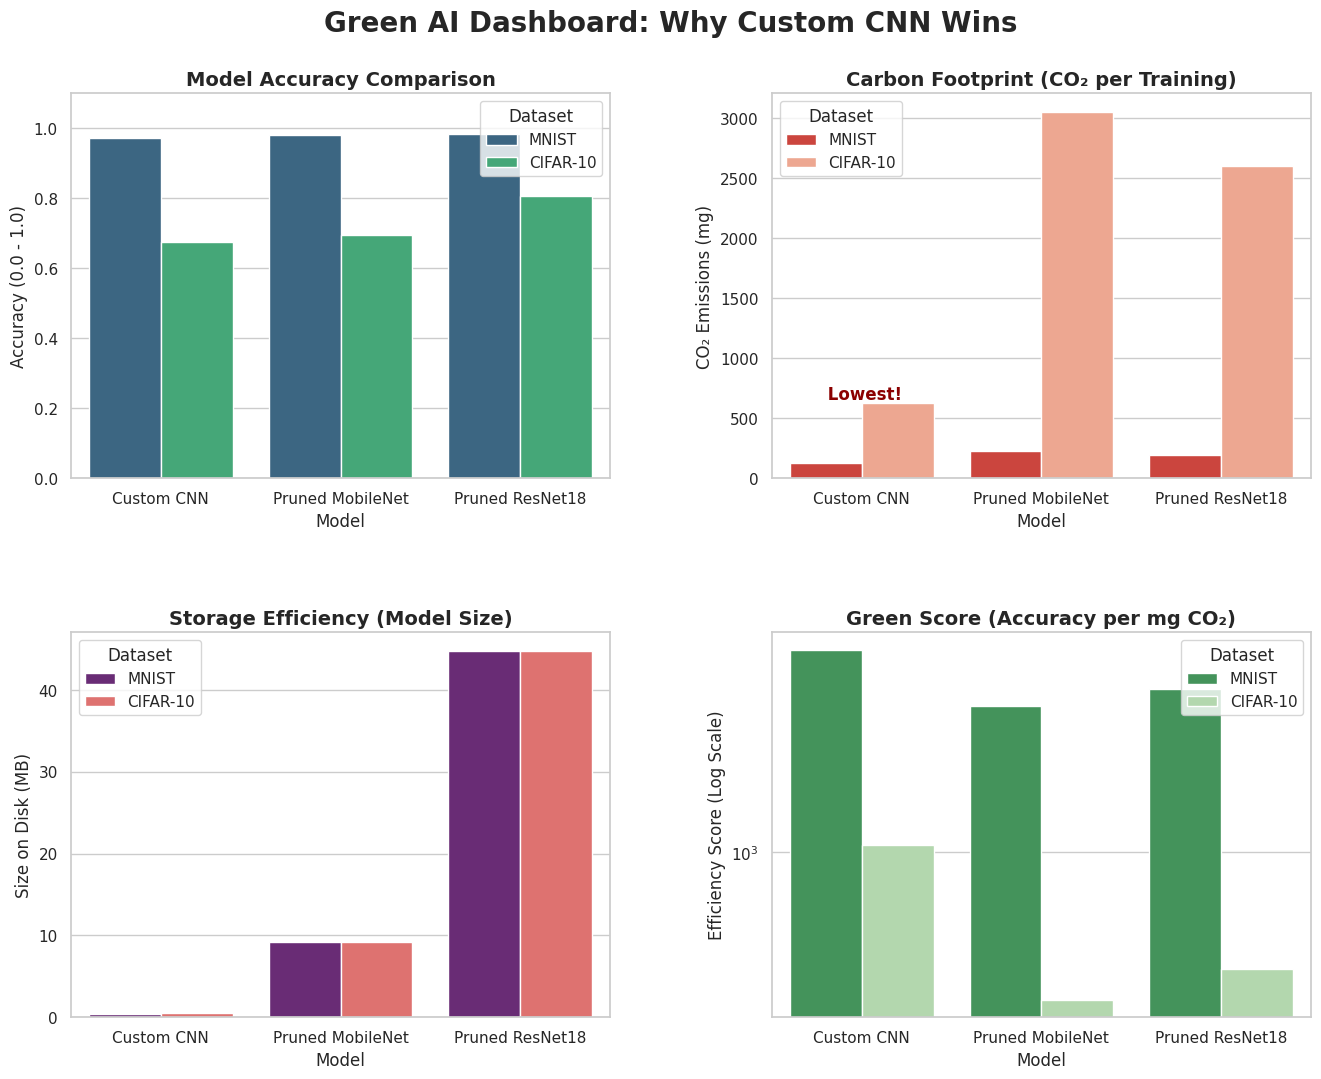

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Combine and Clean Data
mnist_df['Dataset'] = 'MNIST'
cifar_df['Dataset'] = 'CIFAR-10'
df_all = pd.concat([mnist_df, cifar_df])

# Standardize Model Names
df_all['Model'] = df_all['Model'].str.strip().replace('ResNet18 Pruned', 'Pruned ResNet18')

# Calculate Efficiency Score
df_all['Carbon_Efficiency'] = df_all['Accuracy'] / (df_all['CO2 (kg)'] + 1e-10)
df_all['CO2_mg'] = df_all['CO2 (kg)'] * 1e6

# Set visual style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100
colors = ["#2ecc71", "#3498db", "#e74c3c"] # Green, Blue, Red

# ============================================================================
# NEW BAR CHART EDA SUITE
# ============================================================================

# Create a 2x2 grid for a comprehensive dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. ACCURACY BAR CHART (Higher is Better)
sns.barplot(ax=axes[0, 0], data=df_all, x='Model', y='Accuracy', hue='Dataset', palette='viridis')
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy (0.0 - 1.0)')
axes[0, 0].set_ylim(0, 1.1)

# 2. CARBON EMISSIONS BAR CHART (Lower is Better)
sns.barplot(ax=axes[0, 1], data=df_all, x='Model', y='CO2_mg', hue='Dataset', palette='Reds_r')
axes[0, 1].set_title('Carbon Footprint (CO₂ per Training)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('CO₂ Emissions (mg)')
# Annotation to highlight Custom CNN's low footprint
axes[0, 1].text(0, df_all[df_all['Model']=='Custom CNN']['CO2_mg'].max(), ' Lowest!', 
                color='darkred', fontweight='bold', ha='center', va='bottom')

# 3. MODEL SIZE BAR CHART (Lower is Better)
sns.barplot(ax=axes[1, 0], data=df_all, x='Model', y='Size (MB)', hue='Dataset', palette='magma')
axes[1, 0].set_title('Storage Efficiency (Model Size)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Size on Disk (MB)')

# 4. CARBON EFFICIENCY SCORE (Higher is Greener)
sns.barplot(ax=axes[1, 1], data=df_all, x='Model', y='Carbon_Efficiency', hue='Dataset', palette='Greens_r')
axes[1, 1].set_title('Green Score (Accuracy per mg CO₂)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Efficiency Score (Log Scale)')
axes[1, 1].set_yscale('log') # Essential to show the massive difference

# Add a main title
plt.suptitle('Green AI Dashboard: Why Custom CNN Wins', fontsize=20, fontweight='bold', y=0.95)

plt.savefig('green_computing_bar_charts.png', bbox_inches='tight')
plt.show()

